In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

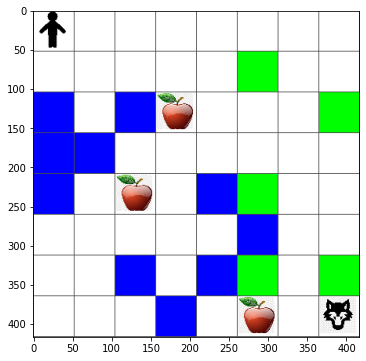

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## 상태 정의

새로운 게임 규칙에서는 각 보드 상태에서 에너지와 피로도를 추적해야 합니다. 따라서 현재 문제 상태에 대한 모든 필요한 정보를 포함하는 `state` 객체를 생성할 것입니다. 여기에는 보드 상태, 현재 에너지와 피로도 수준, 그리고 터미널 상태에서 늑대를 이길 수 있는지 여부가 포함됩니다:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## 보상 함수

### 개요
보상 함수는 에이전트가 환경에서 행동을 선택할 때 사용하는 핵심 요소입니다. 이 함수는 에이전트의 행동이 얼마나 성공적인지 평가하며, 학습 과정에서 중요한 역할을 합니다.

### 설계 고려사항
- **명확성**: 보상은 에이전트가 목표를 이해하고 달성할 수 있도록 명확해야 합니다.
- **균형**: 너무 높은 보상은 과적합을 유발할 수 있고, 너무 낮은 보상은 학습을 방해할 수 있습니다.
- **연속성**: 보상은 에이전트가 지속적으로 개선할 수 있도록 설계되어야 합니다.

### 예제
다음은 간단한 보상 함수의 예제입니다:

```python
def reward_function(state, action):
    if state == "goal":
        return 100  # 목표에 도달했을 때 높은 보상
    elif state == "danger":
        return -50  # 위험한 상태에 대한 페널티
    else:
        return 0  # 중립적인 상태
```

### 일반적인 실수
- **과도한 복잡성**: 너무 복잡한 보상 함수는 에이전트가 학습하기 어렵게 만듭니다.
- **불균형한 보상**: 특정 행동에 과도한 보상을 주면 에이전트가 편향된 학습을 할 수 있습니다.
- **환경과의 불일치**: 보상 함수가 환경의 목표와 일치하지 않으면 학습이 비효율적일 수 있습니다.

### 최적화 팁
- 작은 실험을 통해 보상 함수의 효과를 테스트하세요.
- 보상 구조를 간단하게 유지하면서도 목표를 명확히 반영하도록 설계하세요.
- 에이전트의 행동을 관찰하고 필요에 따라 보상 함수를 조정하세요.

### 결론
보상 함수는 강화 학습에서 성공적인 모델을 구축하는 데 중요한 역할을 합니다. 신중하게 설계된 보상 함수는 에이전트가 목표를 효과적으로 달성할 수 있도록 돕습니다.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-러닝 알고리즘

실제 학습 알고리즘은 거의 변하지 않습니다. 단지 보드 위치 대신 `state`를 사용합니다.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

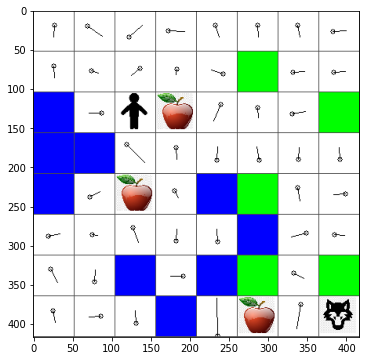

In [11]:
m.plot(Q)

## 결과

피터가 늑대와 싸우도록 훈련시키는 데 성공했는지 확인해봅시다!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


이제 익사 사례가 훨씬 줄어들었지만, 피터는 여전히 늑대를 항상 죽일 수 있는 것은 아닙니다. 하이퍼파라미터를 조정하며 실험을 통해 이 결과를 개선할 수 있는지 확인해 보세요.


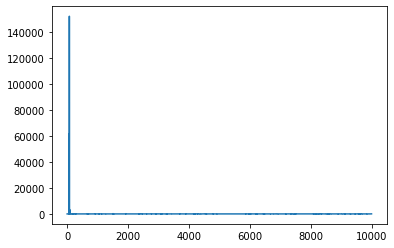

In [13]:
plt.plot(lpath)


---

**면책 조항**:  
이 문서는 AI 번역 서비스 [Co-op Translator](https://github.com/Azure/co-op-translator)를 사용하여 번역되었습니다. 정확성을 위해 최선을 다하고 있지만, 자동 번역에는 오류나 부정확성이 포함될 수 있습니다. 원본 문서의 원어 버전을 권위 있는 출처로 간주해야 합니다. 중요한 정보의 경우, 전문적인 인간 번역을 권장합니다. 이 번역 사용으로 인해 발생하는 오해나 잘못된 해석에 대해 책임을 지지 않습니다.
